# 2014년 이안굿펠로우가 씀ㅎ 
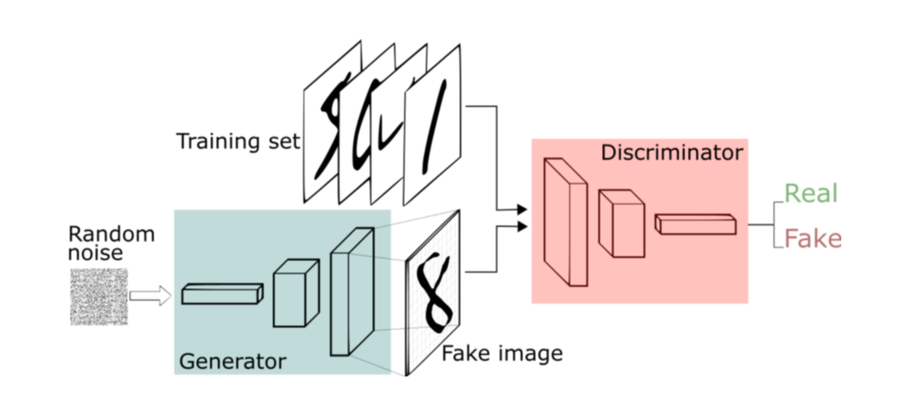

# 모듈 불러오기 

In [1]:

import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


# 데이터 셋 구성하기 

In [2]:

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data() #분류와 달리  y_train, y_test가 필요하지 않습니다. 그래서 언더스코드로 데이터를 무시합니다.

train_x.shape

(50000, 32, 32, 3)

In [3]:
print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 255
min pixel: 0


In [4]:
#이미지 전처리하기 
#학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.
train_x = train_x.astype('float32') #float32로 지정함 이렇게 하면 연산속도가 빨라진다. float64는 정확한 이미지 표현이 가능하지만... #2에 32승만큼 표현하겠다.
train_x = (train_x -127.5)/127.5 #중간값을 0으로 맞춰주기 위해서 

print('max pixel:', train_x.max())
print('min pixel:', train_x.min())
print(train_x.shape) #5만장의 이미지가 있고 사이즈가 32,32,컬러 데이터군요!

max pixel: 1.0
min pixel: -1.0
(50000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

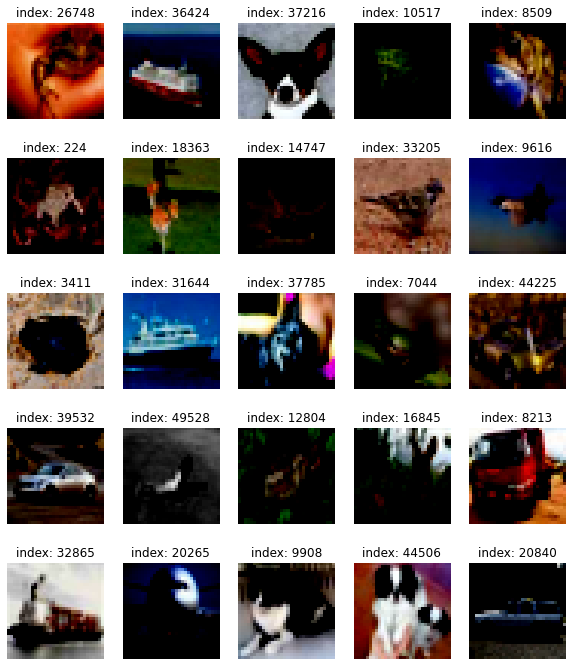

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(10,12))

for i in range(25):
    plt.subplot(5,5,i+1)
    random_index = np.random.randint(50000)
    plt.imshow(train_x[random_index]) 
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

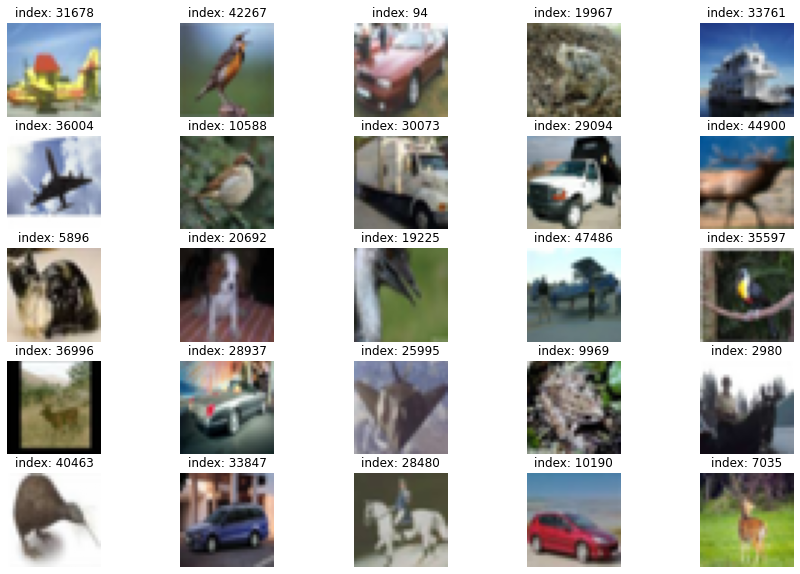

In [6]:
#로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
plt.figure(figsize = (15, 10)) #그림판 크기설정 

for i in range(25):
    plt.subplot(5, 5, i+1) #여러개 띄우고 싶으면 subplot (row,col,index) index가 1부터 시작해야 함
    random_index = np.random.randint(1, 50000) #5만장 중에 랜덤하게 25개 뽑아보겠다!
    plt.imshow((train_x[random_index] +1)/2.0) #아래 에러가 나는 원인응 내가 데이터 타입을 float32로 지정해서 이미지를 겹칠 때 나오는 에러라고 한다. 
    plt.title(f'index: {random_index}')
    plt.axis('off') #축제거 눈금 제거된당

plt.show()
#-1~1로 나오니깐!ㅎ 정규화시켜준다!ㅎ
# Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). +1/2.0을 하지 않으면 나옴
# 이 에러가 뜨면 이미지 값들이 모두 1로 변환되어 합쳐진다고 한다. 그래서 1을 더하고 /2.0을 나눠봤다. 그러면 그대로 일텐데..에러가 사라진다. 
# 형태변환을 해줘야해서 그러나..? 왜 그렇게 했는지는 안나온다. 

In [7]:
BUFFER_SIZE = 50000 #전체 데이터가 5만장이기 때문에...전체데이터를 섞어서 넣어줄 것이기에! 
BATCH_SIZE = 256 #모델을 한번에 학습할 데이터의 양을 나타냅니다. 그냥 256으로 따라해봤다. 
#이거 배치사이즈에 따라서 학습에 영향이 있나요? 네!
#메모리 효율화를 위해서만 하는 것인가요? 아직은 모르겠네요!ㅎ

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)
#`from tensor_slices()`함수를 사용해서 텐서 자료형에서 데이터 셋을 만들 수 있음 이미지가 데이터 셋으로 만들어집니다. 
#잘 섞으려면 buffer_size와 총데이터를 같게 만들어야 합니다. 왜인지는..아직..?ㅜ
#여기에 train_dataset은 어떻게 생겼을까요???
#잘섞여서 256개씩 잘 쌓여져 있겠죠?

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float32>


# #생성자 모델 구현하기 

In [18]:
# dcgan의 모델 
def make_generator_model():
    # Start
    model = tf.keras.Sequential()
    
    # First : Dense layer
    model.add(layers.Dense(8*8*256, use_bias = False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) #가중치가 폭발하지 않도록 가중치 값을 정규화시켜줍니다. 
    model.add(layers.LeakyReLU())
    
    # Second : Reshape Layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(128, kernel_size = (5, 5), strides=(1, 1), padding='same', use_bias = False)) #convtranspose층은 upsampling
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth : Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

#마지막에 tanh를 사용하는 이유는 우리가 이미지를 -1과 1사이로 정규화시켰던 데이터셋과 동일하게 만들기위해서입니다. 
#leakly Relu는 relu와 달리 음수를 갖는다.

![image](https://user-images.githubusercontent.com/68840414/110077365-52717d80-7dc9-11eb-843c-1083980a4bd5.png)

In [19]:
generator = make_generator_model()
generator.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

In [20]:
noise = tf.random.normal([1, 100])

In [21]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

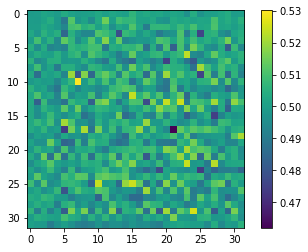

In [22]:
#그려보기 
plt.imshow((generated_image[0, :, :, 0]+1)/2.0)
plt.colorbar()
plt.show()

# 판별자 모델 구현하기 

In [23]:

#(32,32,3)이미지를 입력받아서 1차원으로 출력합니다. 

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1)) #진짜인지 가짜인지만 판별하면 되니깐

    return model

In [24]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [25]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0021687]], dtype=float32)>

# 손실함수와 optimizer 구현하기 

In [26]:
# 그냥 cross entropy를 불러오면 정규화시키는 sigmoid나 tanh함수같은 활성화함수가 없음. 그래서 모든 실숫값이 나오기에 binarycrossentropy를 사용
#sigmoid함수를 활용해서 0~1사이의 값으로 정규화시켜줍니다. 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [28]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [29]:
#학습이 1로 나오면 위조지폐가 fake output과 real output의 차이가 크다는 의미. 좋지 않는 위조지폐가 만들어졌다는 의미. 서서히 0.5로 가는게 좋기에
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [30]:
# 학습이 따로 이루어지기 때문에 optimizer를 따로 만들어줍니다. 
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [31]:
noise_dim = 100 #100차원의 노이즈 생성
num_examples_to_generate = 16 #노이즈를 16개 만들자!

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 훈련과정 상세 기능 구현하기 

In [32]:

#데코레이터라고 부른다. 
@tf.function #그냥 받으면 numpy array 형태인데 tensorflow graph로 변환
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [33]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1)/2.0)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [34]:

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [35]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 학습 과정 진행하기 

In [36]:


def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss' : [], 'disc_loss' : [], 'real_accuracy' : [], 'fake_accuracy': []}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print("Epoch {} iter {}".format(epoch+1, it+1))
                print("Time for epoch {} : {} sec".format(epoch+1, int(time.time() - epoch_start)))
            
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        display.clear_output(wait = True)
        generate_and_save_images(generator, epochs, it, seed)
        print("Time for training : {} sec".format(int(time.time() - start)))
        
        draw_train_history(history, epoch)

In [37]:
save_every = 5
EPOCHS = 50

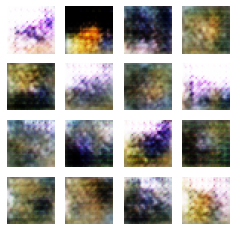

Time for training : 599 sec


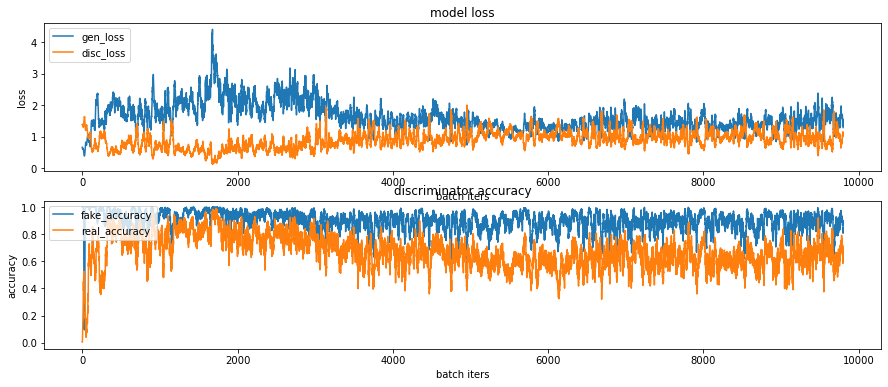

CPU times: user 9min 50s, sys: 16.7 s, total: 10min 7s
Wall time: 10min


In [38]:
%%time
train(train_dataset, EPOCHS, save_every)

# gif 파일로 만들어보도록 하겠습니다. 

In [39]:
gif_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(gif_file, mode='I') as writer:
    filenames = glob.glob('./data/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    
    for i, filename in enumerate(filenames):
        frame = 2 * (i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ./data

NameError: name 'filename' is not defined

In [ ]:
checkpoint_dir = os.path.dirname(os.path.abspath('__file__')) + r'/data/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해봅시다 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0]+1)/2.0)
plt.show()

# GAN 훈련과정 개선하기
옵션을 변경합니다. 
epochs = 100번 추가하기 

In [ ]:



checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [ ]:
save_every = 5
EPOCHS = 100

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# gan 기본이라도 알고가자.
![image](https://user-images.githubusercontent.com/68840414/110090248-6bcef580-7dda-11eb-9146-7d2b52dfa84a.png)

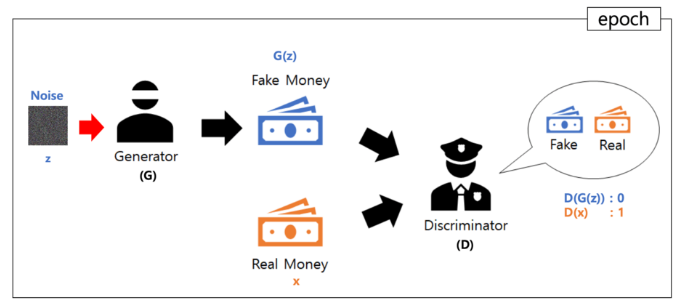

discriminator모델:

generator모델:
    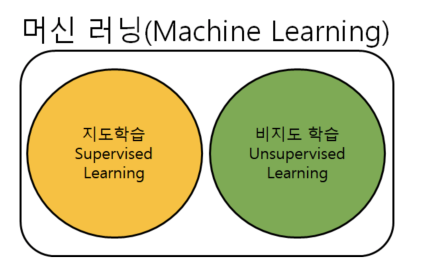

# generator의 입장

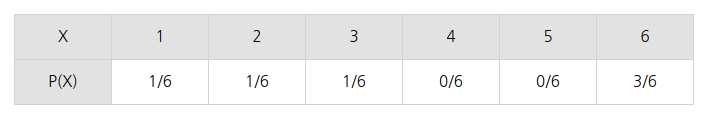

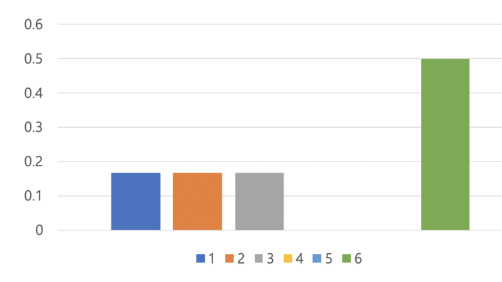

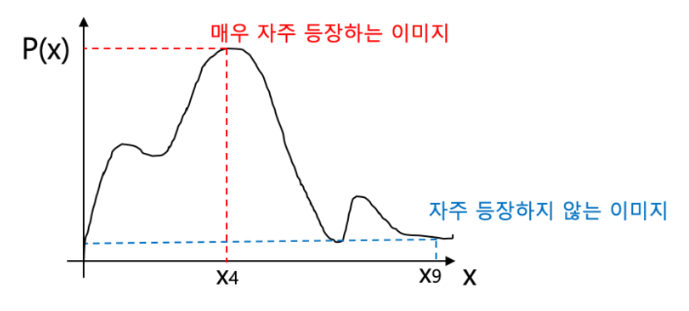

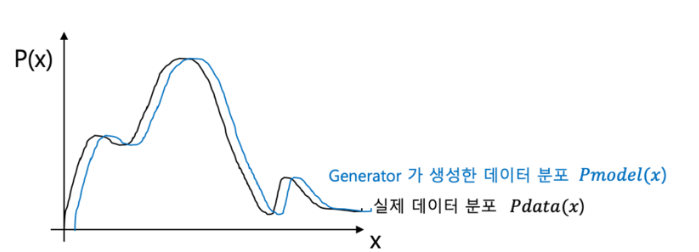

### discriminator에 들어가서 결과값이 1(진짜 돈)이라고 나오는게 목표이다.
![image](https://user-images.githubusercontent.com/68840414/110090248-6bcef580-7dda-11eb-9146-7d2b52dfa84a.png)

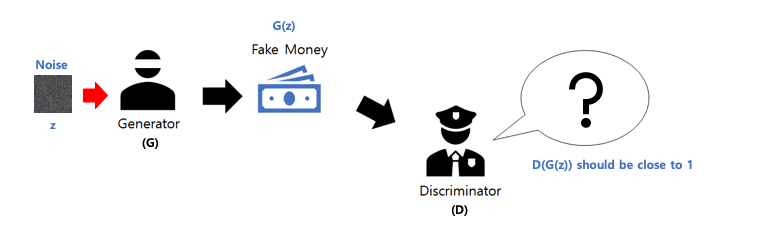

# discriminator모델 
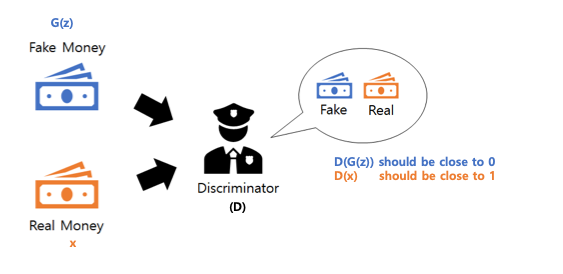

## 수식으로 보는 gan

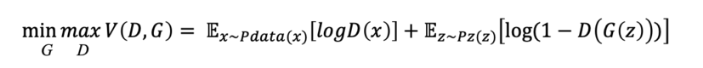

# discriminator의 입장에서 보면!
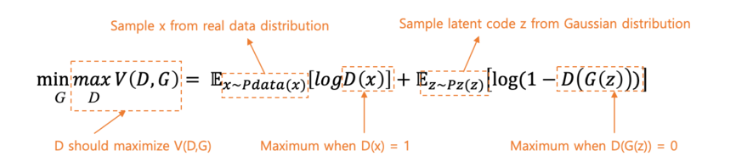

* gan의 loss가 v(D,G)인데 이것에 최대가 되도록하는 것이 목표이다. 
* D는 경찰이고, 가짜 데이터가 들어오면 0을 출력, 진짜 데이터가 들어오면 1을 출력한다. 
* x는 진짜 데이터고, G(z)는 Generator가 z를 가지고 만든 가짜 데이터이다. 
* D는 D(x) = 1이 되도록 해야하고, D(G(z)) = 0이 되도록 하는 것이 최대 목표이다. 

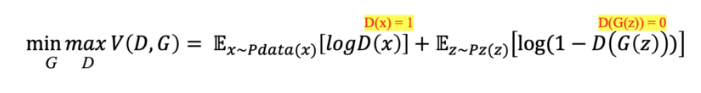

![image](https://user-images.githubusercontent.com/68840414/110075427-21dc1480-7dc6-11eb-9312-1cd763ee1bbf.png)

#### 이렇게 하면 log(1) = 0이 되어서 값이 0이 되는데.. 아까 시그모이드 사용해서 0~ 1사이 분포로 나타내게 하고 싶다고 했고?  그나마 가장 큰 값이라는데.....

결국은 이게 0으로 가는것을 max한다는 것인데...

# generator입장

![image](https://user-images.githubusercontent.com/68840414/110075609-6962a080-7dc6-11eb-9fee-004cdc13fc2e.png)

* g는 위조지폐범이고 경찰과 반대로 진짜 데이터는 관심없고, 가짜로 만든 것을 제대로 판별하는지가 중요하다. 
* x는 진짜 데이터이고, G(z)는 generator가 만든 위조지폐이다. 
* D(g(z)) = 1이 되게 해야한다. 

![image](https://user-images.githubusercontent.com/68840414/110075853-d5450900-7dc6-11eb-923d-2e2a454c165e.png)


# loss function

1번 회귀에 많이 쓰는 mse
![image](https://user-images.githubusercontent.com/68840414/110076166-61573080-7dc7-11eb-9e1a-cc4cefa37564.png)


2번 정답값이 원핫인코딩인 것만 쓸 수 있는 cross entropy

![image](https://user-images.githubusercontent.com/68840414/110076405-c743b800-7dc7-11eb-8cb4-fd4724a674a4.png)


![image](https://user-images.githubusercontent.com/68840414/110076879-8dbf7c80-7dc8-11eb-940b-e0b912ccbe72.png)